In [6]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [7]:
# Dataset (using TensorFlow's built-in dataset for ease of use)
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file("flower_photos", dataset_url, untar=True)

In [8]:
print(dataset_dir)  # Check the full path to the dataset

C:\Users\ahmed\.keras\datasets\flower_photos


In [9]:
dataset_dir = 'C:/Users/ahmed/.keras/datasets/flower_photos'
print(os.listdir(dataset_dir))  # List contents of the flower_photos directory

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']


In [10]:
# Remove LICENSE.txt if it exists
license_file = os.path.join(dataset_dir, 'LICENSE.txt')
if os.path.exists(license_file):
    os.remove(license_file)

# Create train and validation directories
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')

# Create these directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all flower class directories
flower_classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Loop through each flower class and split into train and validation sets
for flower_class in flower_classes:
    flower_class_path = os.path.join(dataset_dir, flower_class)
    if os.path.isdir(flower_class_path):
        # List all image files in the class directory
        images = [img for img in os.listdir(flower_class_path) if img.endswith('.jpg')]

        # Split into train and validation sets (80% train, 20% validation)
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        # Create class-specific subdirectories for train and validation
        class_train_dir = os.path.join(train_dir, flower_class)
        class_val_dir = os.path.join(val_dir, flower_class)
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_val_dir, exist_ok=True)

        # Move images to train and validation directories
        for image in train_images:
            shutil.move(os.path.join(flower_class_path, image), os.path.join(class_train_dir, image))
        for image in val_images:
            shutil.move(os.path.join(flower_class_path, image), os.path.join(class_val_dir, image))

print("Dataset has been split into train and validation directories.")

Dataset has been split into train and validation directories.


In [11]:
# Image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches from the train and validation directories
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 2934 images belonging to 5 classes.
Found 736 images belonging to 5 classes.


In [12]:
# Load MobileNetV2 pre-trained on ImageNet
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', 
                                               input_shape=(224, 224, 3), 
                                               include_top=False)

# Freeze the base model to avoid training on it
base_model.trainable = False

# Add custom layers on top of MobileNetV2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # We have 5 classes: daisy, dandelion, roses, sunflowers, tulips
])

In [13]:
# Compile and Train the Model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model using the train and validation generators
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=val_generator)

Epoch 1/10
92/92 [==============================] - 123s 1s/step - loss: 0.7213 - accuracy: 0.7365 - val_loss: 0.4408 - val_accuracy: 0.8397
Epoch 2/10
92/92 [==============================] - 87s 940ms/step - loss: 0.4642 - accuracy: 0.8292 - val_loss: 0.4504 - val_accuracy: 0.8342
Epoch 3/10
92/92 [==============================] - 85s 917ms/step - loss: 0.3942 - accuracy: 0.8507 - val_loss: 0.3912 - val_accuracy: 0.8587
Epoch 4/10
92/92 [==============================] - 84s 914ms/step - loss: 0.3538 - accuracy: 0.8729 - val_loss: 0.4082 - val_accuracy: 0.8696
Epoch 5/10
92/92 [==============================] - 86s 932ms/step - loss: 0.3696 - accuracy: 0.8626 - val_loss: 0.3677 - val_accuracy: 0.8560
Epoch 6/10
92/92 [==============================] - 84s 914ms/step - loss: 0.3408 - accuracy: 0.8701 - val_loss: 0.3437 - val_accuracy: 0.8872
Epoch 7/10
92/92 [==============================] - 86s 933ms/step - loss: 0.2919 - accuracy: 0.8960 - val_loss: 0.3532 - val_accuracy: 0.8832
E

In [14]:
# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

23/23 [==============================] - 10s 419ms/step - loss: 0.3596 - accuracy: 0.8764
Validation Loss: 0.35956767201423645
Validation Accuracy: 0.876358687877655


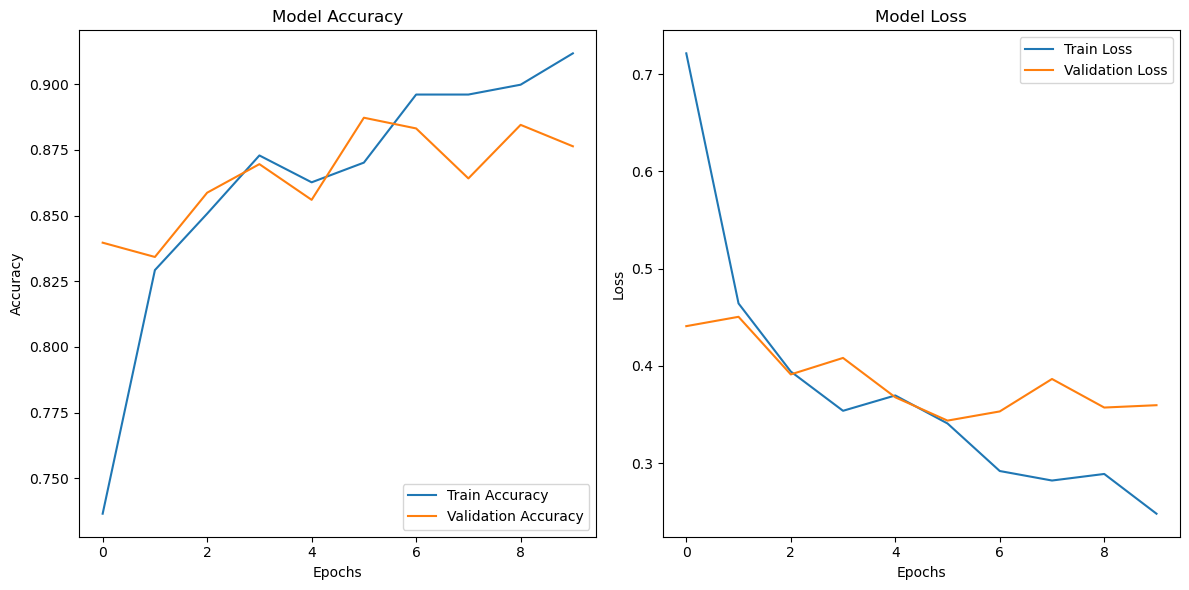

In [15]:
# Plotting Training and Validation Accuracy/Loss Curves
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

23/23 [==============================] - 11s 426ms/step


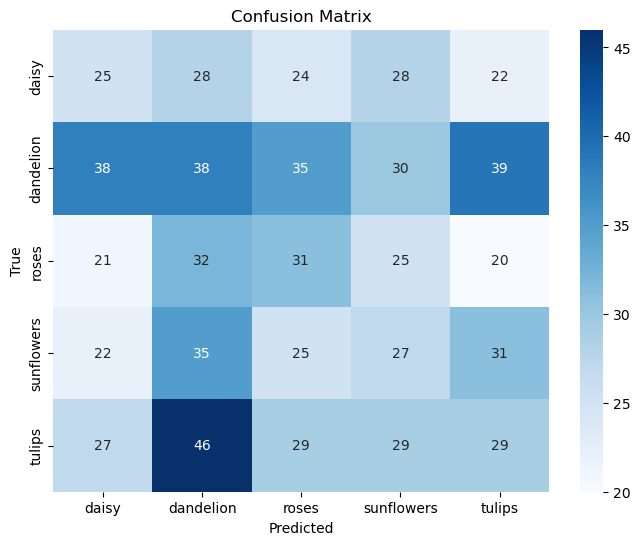

Classification Report:
               precision    recall  f1-score   support

       daisy       0.19      0.20      0.19       127
   dandelion       0.21      0.21      0.21       180
       roses       0.22      0.24      0.23       129
  sunflowers       0.19      0.19      0.19       140
      tulips       0.21      0.18      0.19       160

    accuracy                           0.20       736
   macro avg       0.20      0.20      0.20       736
weighted avg       0.20      0.20      0.20       736



In [16]:
# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict the classes of the validation data
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))

1/1 [==============================] - 1s 1s/step


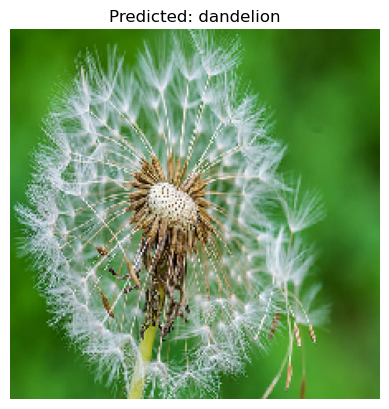

In [17]:
# Model Predictions on Test Data
import random
from tensorflow.keras.preprocessing import image

# Randomly select an image from the validation set
random_index = random.randint(0, len(val_generator.filenames) - 1)
img_path = os.path.join(val_dir, val_generator.filenames[random_index])

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict the class
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

# Display the image and predicted class
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()